# Lyapunov Analysis

This notebook reads data from a run of the Ginelli algorithm and then has some basic functions for plotting the output.

In [145]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc # Latex for plots
from scipy.interpolate import interp1d
rc('text', usetex=True)

from scipy.stats import gaussian_kde

### Defining Data Class

This will be data object. It reads the raw data from a run and then processes it according to a specified averaging time for the FTLEs. Recall that the raw data has stretching info from each QR step. This is not necessarily the same as the averaging time for calculating FTLEs.

It also contains methods for basic info on run parameters and summary statistics.

In [146]:
class DataRead: # THINK ABOUT BENEFITS OF THIS BEING READ AS PD ARRAY 
    """Class for reading data from a L63 Lyapunov Analysis run
    Parameter, directory, string: Directory containing data files.
    Parameter, L, integer: L * tau is the averaging time for the FTLES. L must divide raw sample lengths.
    """

    def __init__(self, dirName, L): # Add a load feature, as processing is slow
        self.directory = dirName
        
        # Raw FTLEs data
        self.FTBLEraw = np.load(dirName + '/Data/FTBLE.npy') # This is for L = 1, i.e. growth just over time tau
        self.FTCLEraw = np.load(dirName + '/Data/FTCLE.npy')
        
        # Processed FTLE
        self.FTBLE = self.process(self.FTBLEraw, L) 
        self.FTCLE = self.process(self.FTCLEraw, L)
        
        self.CLE = np.load(dirName + '/Data/CLE.npy')
        self.BLE = np.load(dirName + '/Data/BLE.npy')
        self.CLVs = np.load(dirName + '/Data/CLVs.npy')
        self.BLVs = np.load(dirName + '/Data/BLVs.npy')
        self.solution = np.load(dirName + '/Data/solution.npy')
        infile = open(self.directory +'/parameters','rb')
        self.param_dict = pickle.load(infile)
        infile.close()
        
        self.L = L # Averaging time
        self.samples = len(self.FTCLE) #THIS NEEDS THINKING ABOUT IN LIGHT OF L NOW BEING ARBITRARY

    def who(self):
        "Prints the parameters associated with the run."
        print(f'The parameters used to generate this data were:\n{self.param_dict}')
        return
    
    def stats(self):
        "Returns a dictionary with summary statistics."
        ss_dict ={'FTBLE Means': np.mean(self.FTBLEraw, axis = 0),
                  'FTCLE Means': np.mean(self.FTCLEraw, axis = 0),
                  'CLE Check Sum': np.sum(self.CLE[0]),
                  'BLE Check Sum': np.sum(self.BLE[-1])}
        return ss_dict
    
    def process(self, raw, L): # THIS IS SLOW
        FTLE = [[np.mean(raw[0:L, 0]), np.mean(raw[0:L, 1]), np.mean(raw[0:L, 2])]]
        for i in range(L, len(raw) - len(raw)%L , L):
            # If L doesn't divide len(raw) exactly, we throw away last block less than length L

            means = [ [np.mean(raw[i:i + L, 0]) , np.mean(raw[i:i + L, 1]) , np.mean(raw[i:i + L, 2])] ]
            FTLE = np.append(FTLE, means, axis = 0)
        return FTLE
          

### Read and Process the raw data

In [203]:
less_precise = 'tau0.1-steps1.1E+06KUPTSOV'
avg10_0_01 = DataRead('tau0.01-steps1.1E+06', 1000)
avg10_0_1 = DataRead(less_precise, 1000)

In [198]:
avg0_1 = DataRead('tau0.01-steps1.1E+06', 10)
avg0_5 = DataRead('tau0.01-steps1.1E+06', 50)
avg1 = DataRead('tau0.01-steps1.1E+06', 100)
avg2_5 = DataRead('tau0.01-steps1.1E+06', 250)
avg5 = DataRead('tau0.01-steps1.1E+06', 500)
avg6 = DataRead('tau0.01-steps1.1E+06', 600)
avg7 = DataRead('tau0.01-steps1.1E+06', 700)
avg7_5 = DataRead('tau0.01-steps1.1E+06', 750)
avg8_0 = DataRead('tau0.01-steps1.1E+06', 800)
avg8_5 = DataRead('tau0.01-steps1.1E+06', 850)
avg9_0 = DataRead('tau0.01-steps1.1E+06', 900)
avg9_5 = DataRead('tau0.01-steps1.1E+06', 950)
avg10 = DataRead('tau0.01-steps1.1E+06', 1000)

In [199]:
avg20 = DataRead('tau0.01-steps1.1E+06', 2000)
avg50 = DataRead('tau0.01-steps1.1E+06', 5000)

In [200]:
avg100 = DataRead('tau0.01-steps1.1E+06', 10000)

In [201]:
# Space for checking everything is read in correctly
avg1000 = DataRead('tau0.01-steps1.1E+06', 100000)

## FTLE Density Function Definitions

We define three functions for plotting densities. One for the FTCLEs, which allows to compare for different averaging times as well an equivalent one for the FTBLEs. Finally, there is also a function for comparing the densities between the FTBLEs and FTCLEs for a fixed averaging time.

Note that all three functions make use of KDE which you can read more about here: 

https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

Finally note, there are equivalent functions relying on histograms at the bottom of the notebook.

In [157]:
def cle_density(data, leindex, save = False):
    """ Function for estimating the FTCLE density via KDE.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    option, save: boolean.
    """
    labels = ['$\\bar{\\lambda}_1 ^C$', '$\\bar{\\lambda}_2 ^C$', '$\\bar{\\lambda}_3 ^C$']    
    
    for le in leindex: # Loop over LE indexes
        
        j = le - 1 # Python index is 1 less than LE index        plt.figure()
        
        for i in data: # This loop produce the histograms for different tau
            
            # Info we need for pltos
            Ltau = i.L * i.param_dict['tau']
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            FTCLE = i.FTCLE[:, j]
            
            # KDE setup 
            x_d = np.linspace(FTCLE.min(), FTCLE.max(), 1000) # Grid we evaluate PDF on
            kde = gaussian_kde(FTCLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
            pdf = kde.evaluate(x_d)
            
            # Plotting Histogram
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            plt.plot(x_d, pdf, label = label)   
            # plt.plot(FTCLE, np.full_like(FTCLE, -0.01), '.k') NICE FOR ADDING DATA POINTS TO PLOT
                    
        plt.title(f'{labels[j]} Density Comparison') # Plot features
        plt.xlabel(f'{labels[j]}')
        plt.ylabel('$\\rho$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'FTCLE{le}-Densities.png', dpi=1200)
        else:    
            plt.show()

In [158]:
def ble_density(data, leindex, save = False):
    """ Function for estimating the FTCLE density via KDE.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    option, save: boolean.
    """
    labels = ['$\\bar{\\lambda}_1 ^B$', '$\\bar{\\lambda}_2 ^B$', '$\\bar{\\lambda}_3 ^B$']    
    
    for le in leindex: # Loop over LE indexes
        
        j = le - 1 # Python index is 1 less than LE index
        plt.figure()
        
        for i in data: # This loop produce the histograms for different tau
            
            # Info we need for pltos
            Ltau = i.L * i.param_dict['tau']
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            FTBLE = i.FTBLE[:, j]
            
            # KDE setup 
            x_d = np.linspace(FTBLE.min(), FTBLE.max(), 1000) # Grid we evaluate PDF on
            kde = gaussian_kde(FTBLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
            pdf = kde.evaluate(x_d)
            
            # Plotting Histogram
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            plt.plot(x_d, pdf, label = label)   
            # plt.plot(FTCLE, np.full_like(FTCLE, -0.01), '.k') NICE FOR ADDING DATA POINTS TO PLOT
                    
        plt.title(f'{labels[j]} Density Comparison') # Plot features
        plt.xlabel(f'{labels[j]}')
        plt.ylabel('$\\rho$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'FTBLE{le}-Densities.png', dpi=1200)
        else:    
            plt.show()

In [159]:
# Comparing FTBLE and FTCLE histograms for a fixed averaging time

def comp_density(data, leindex, save = False):
    """ Function for plotting histograms comparison of FTBLEs and FTCLEs.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    """
    labels = ['$\\lambda_1$', '$\\lambda_2$', '$\\lambda_3$']
    Ltau = data.L * data.param_dict['tau'] # SHOULD BE THE SAME FOR DATAB AND DATAC, this L * tau
        
    for le in leindex: # Loop over LE indexes
        
        j = le - 1 # Python index is 1 less than LE index
        # Data
        FTBLE = data.FTBLE[:, j]
        FTCLE = data.FTCLE[:, j]
        
        # KDE setup 
        x0 = min(FTBLE.min(), FTCLE.min()) # Figure limits
        x1 = max(FTBLE.max(), FTCLE.max())
        x_d = np.linspace(x0, x1, 1000) # Grid we evaluate PDF on
        kdeb = gaussian_kde(FTBLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        kdec = gaussian_kde(FTCLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        pdfb = kdeb.evaluate(x_d)
        pdfc = kdec.evaluate(x_d)

        # Plotting Density
        
        plt.plot(x_d, pdfb, label = 'FTBLE')  
        plt.plot(x_d, pdfc, label = 'FTCLE')   
        # plt.plot(FTCLE, np.full_like(FTCLE, -0.01), '.k') NICE FOR ADDING DATA POINTS TO PLOT
        
        plt.title(f'{labels[j]} Density, ' + '$L\\tau =' + f"{Ltau:.2f}" + '$') # Plot features
        plt.ylabel('$\\rho$')
        plt.xlabel(f'{labels[j]}')
        plt.legend()
        

        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'Density-Ltau={Ltau:.2f}-FTBLE{j}vsFTCLE{j}.png', dpi = 1200)
        else:    
            plt.show() 

## Plotting the Densities

Here we actually plot some densities. Note the plotting functions also have options for saving, although this is slow as the images are saved at high quality.

SOMETHING TO THINK ABOUT WOULD BE WRITING CODE TO SAVE PLOTS IN ORDERED FILE STRUCTURE FOR WHEN YOU MAKE LOTS OF THEM.

### Comparing densities for a fixed averaging time.

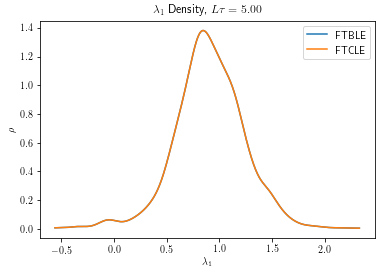

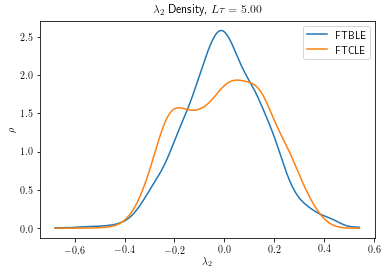

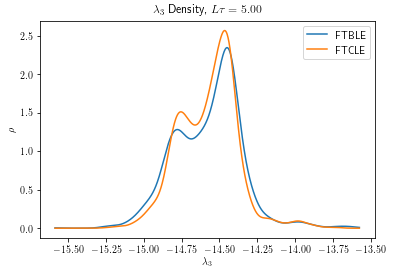

In [151]:
comp_density(avg5, [1, 2, 3])

When the averaging time is longer, the differences between the densities is less pronounced.

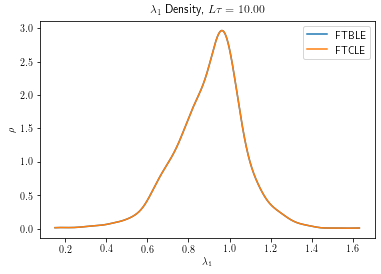

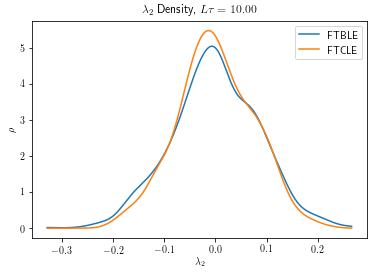

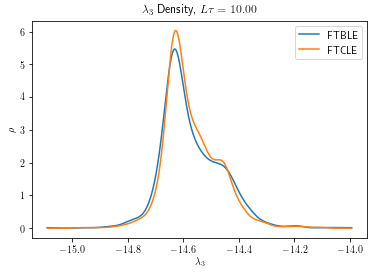

In [18]:
comp_density(avg10, [1, 2, 3])

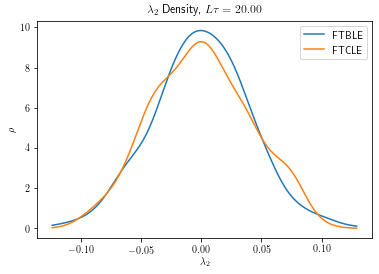

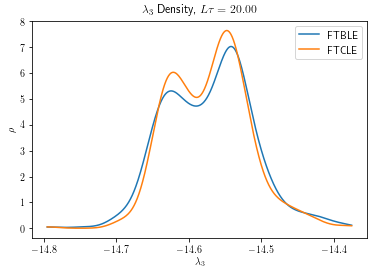

In [186]:
comp_density(avg20, [2, 3])

### Seeing how FTCLE densities changes with averaging time.

Change over a long range of averaging times 

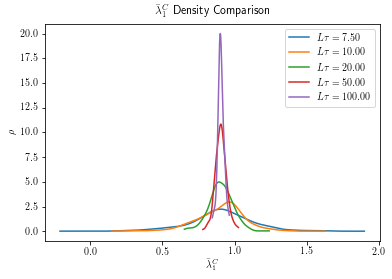

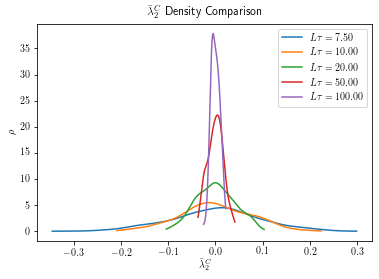

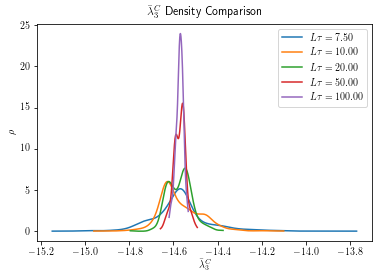

In [184]:
cle_density([avg7_5, avg10, avg20, avg50, avg100], [1, 2, 3])

### Seeing how FTBLE densities changes with averaging time.

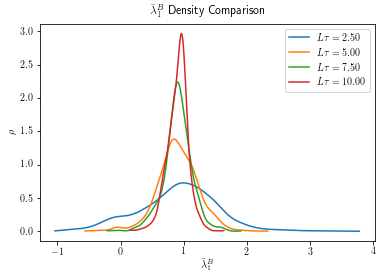

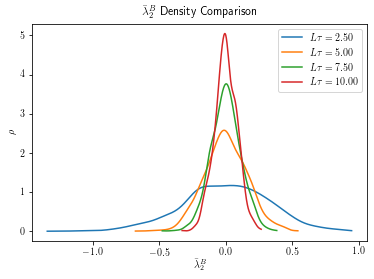

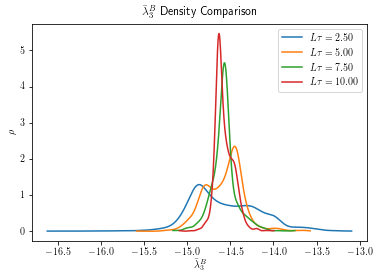

In [16]:
ble_density([avg2_5, avg5, avg7_5, avg10], [1, 2, 3])

# Rate Functions

We define three plotting functions for looking at the rate functions.

One for the FTCLE rate. One for the FTBLE rate. Both of these allow you compare the rates for different averaging times.

Finally we have one for comparing the FTCLE and FTBLE rates for a fixed averaging time.

The pdfs used to calculate the rates are based on KDE.

In [43]:
def clerate(data, leindex, save = False):
    """ Function for plotting rate function of FTCLEs.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    option, save: boolean.
    """
    for j in leindex: # Loop over LE indexes
        lelabel = ['$\\bar{\\lambda}_1 ^C$', '$\\bar{\\lambda}_2 ^C$', '$\\bar{\\lambda}_3 ^C$']
        plt.figure()
        index = j - 1 # Python indexing is one less than intuitive LE index
        
        for i in data: # This loop produce the histograms for different tau
            
            # Info we need for pltos
            Ltau = i.L * i.param_dict['tau']
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            FTCLE = i.FTCLE[:, index]
            
            # KDE setup 
            x_d = np.linspace(FTCLE.min(), FTCLE.max(), 1000) # Grid we evaluate PDF on
            kde = gaussian_kde(FTCLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
            pdf = kde.evaluate(x_d)
            
            # Calcualting Rate Function
            rate = - (np.log(pdf) / Ltau)
            
            # Plotting Rate Function
            plt.plot(x_d, rate, label = label )
        
        plt.title(f'{lelabel[index]} Rate Functions') # Plot features
        plt.xlabel(f'{lelabel[index]}')
        plt.ylabel('$s$(' + lelabel[index] + '$)$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'FTCLE{j}-Rates.png', dpi=1200)
        else:    
            plt.show() 
        

In [110]:
def blerate(data, leindex, save = False):
    """ Function for plotting rate function of FTBLEs.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    option, save: boolean.
    """

    for j in leindex: # Loop over LE indexes
        lelabel = ['$\\bar{\\lambda}_1 ^B$', '$\\bar{\\lambda}_2 ^B$', '$\\bar{\\lambda}_3 ^B$']
        plt.figure()
        index = j - 1 # Python indexing is one less than intuitive LE index
        
        for i in data: # This loop produce the histograms for different tau
            
            # Info we need for pltos
            Ltau = i.L * i.param_dict['tau']
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            FTBLE = i.FTBLE[:, index]
            
            # KDE setup 
            x_d = np.linspace(FTBLE.min(), FTBLE.max(), 1000) # Grid we evaluate PDF on
            kde = gaussian_kde(FTBLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
            pdf = kde.evaluate(x_d)
            
            # Calcualting Rate Function
            rate = - (np.log(pdf) / Ltau)
            
            # Plotting Rate Function
            plt.plot(x_d, rate, label = label)
            
        
        plt.title(f'{lelabel[index]} Rate Functions') # Plot features
        plt.xlabel(f'{lelabel[index]}')
        plt.ylabel('$s$(' + lelabel[index] + '$)$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'FTBLE{j}-Rates.png', dpi=1200)
        else:    
            plt.show() 
        

In [142]:
# Rate Function for BLEs

def comprate(data, leindex, save = False):
    """ Function for plotting rate function of comparison.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    option, save: boolean.
    """
    Ltau = data.L * data.param_dict['tau']
    
    for le in leindex: # Loop over LE indexes
        lelabel = ['$\\lambda_1$', '$\\lambda_2$', '$\\lambda_3$']
        actual_les = [0.91, 0, -14.6]

        
        index = le - 1 # Python index is 1 less than LE index
        # Data
        FTBLE = data.FTBLE[:, index]
        FTCLE = data.FTCLE[:, index]
        
        # KDE setup 
        x0 = min(FTBLE.min(), FTCLE.min()) # Figure limits
        x1 = max(FTBLE.max(), FTCLE.max())
        x_d = np.linspace(x0, x1, 1000) # Grid we evaluate PDF on
        kdeb = gaussian_kde(FTBLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        kdec = gaussian_kde(FTCLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        pdfb = kdeb.evaluate(x_d)
        pdfc = kdec.evaluate(x_d)
        
        # Calcualting Rate Function
        rateb = - (np.log(pdfb) / Ltau)
        ratec = - (np.log(pdfc) / Ltau)

        # Plotting Rates
        
        plt.plot(x_d, rateb, label = 'FTBLE')  
        plt.plot(x_d, ratec, label = 'FTCLE') 
        plt.plot(x_d, np.full_like(x_d, 0), '--k') # Zero Line
        plt.plot(np.full_like(np.arange(-0.5, 0.5, 0.1), actual_les[index]), 
                 np.arange(-0.5, 0.5, 0.1), '--g', label = 'Actual ' + lelabel[index]) # Actual LE, vertical line
        # plt.plot(FTCLE, np.full_like(FTCLE, -0.01), '.k') NICE FOR ADDING DATA POINTS TO PLOT

        plt.title(f'{lelabel[index]} Rate Function Comparison, $L\\tau = {Ltau:.2f} $') # Plot features
        plt.xlabel(f'{lelabel[index]}')
        plt.ylabel('$s$(' + lelabel[index] + '$)$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'Rates-Ltau{Ltau:.2f}-CLE{j}vsBLE{j}.png', dpi=1200)
        else:    
            plt.show() 

## Plotting the Rate Functions

### CLE Rate Functions

Comparing FTCLE rate functions for varying averaging time.

First let's look at how they change over a long range of averaging times.

For $\bar{\lambda} _1 ^ C$ the collapse to a universal rate function seems the most clear. Less certain for $\bar{\lambda} _2 ^ C$ and $\bar{\lambda} _3 ^ C$.

Let's now look for small range of averaging times, closer to $10$.

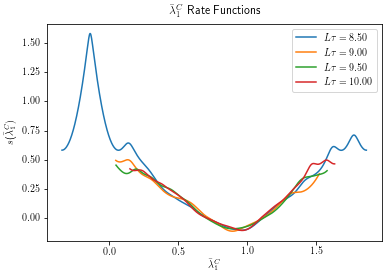

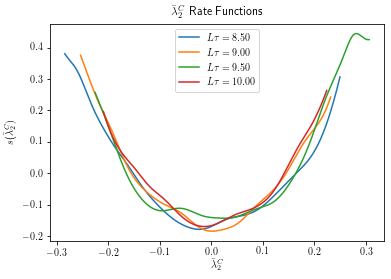

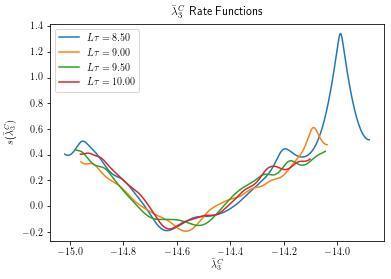

In [121]:
clerate([avg8_5, avg9_0, avg9_5, avg10], [1, 2, 3])

In [ ]:
clerate([avg20, avg50, avg100], [1, 2, 3])

From the above, I'm convinced that first one is converging. There's some qualitive convegence for the other two, namely slopes and symmetry vs. asymettry around the minima the same. 

However, minima, a crucial aspect of the rate function seems to fluctuate.

As a next step, I would do the above analysis but with more data.

### FTBLE Rate Functions

Comparing FTBLE rate functions for varying averaging time.

First we look at broad range of averaging times to see if we have convergence.

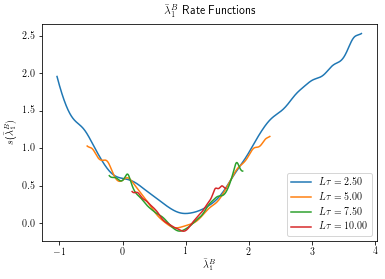

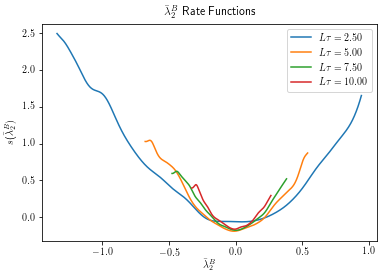

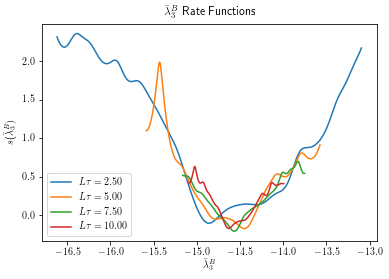

In [122]:
blerate([avg2_5, avg5, avg7_5, avg10], [1, 2, 3])

First two seem to have some kind of convergence. Third, less so. Let's look closer.

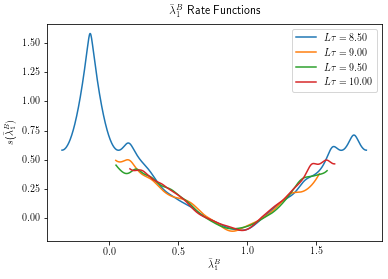

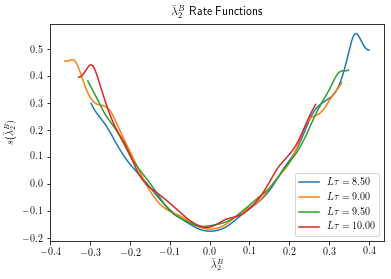

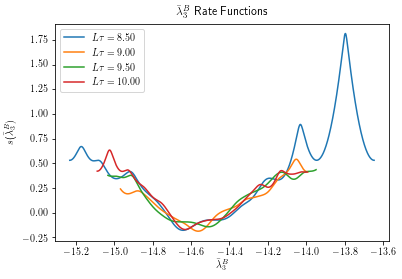

In [124]:
blerate([avg8_5, avg9_0, avg9_5, avg10], [1, 2, 3])

Pretty happy with convergence of first two. Third one is more qualitative. 

### Comparison for fixed averaging time.

From the previous, it looks the biggest differences are in second and third, as expected

Indeed if you look,the CLE rate functions seem to exhibit exponential asymptotic behaviour. The BLE not.

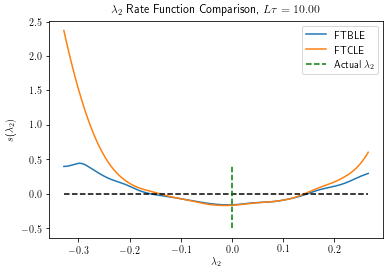

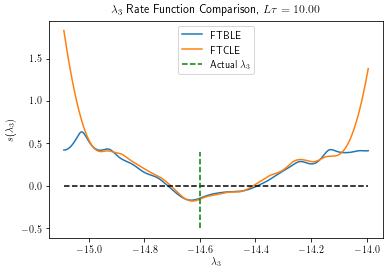

In [125]:
comprate(avg10, [2, 3])

Let's look at how the second ones converge

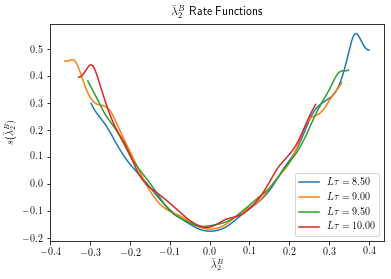

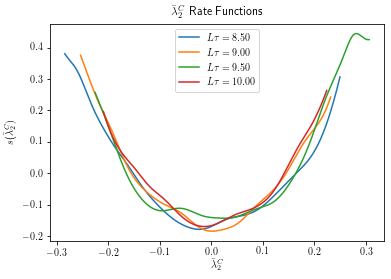

In [126]:
blerate([avg8_5, avg9_0, avg9_5, avg10], [2])
clerate([avg8_5, avg9_0, avg9_5, avg10], [2])

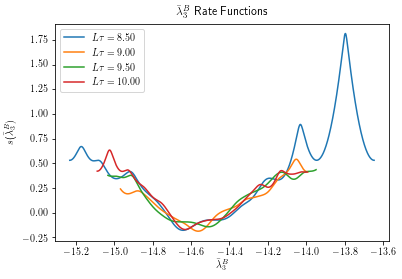

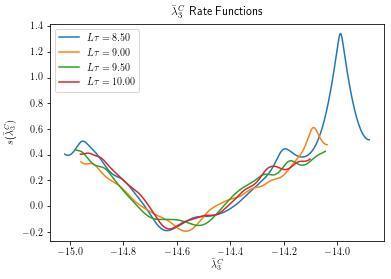

In [127]:
blerate([avg8_5, avg9_0, avg9_5, avg10], [3])
clerate([avg8_5, avg9_0, avg9_5, avg10], [3])

# Angles

THIS CODE WILL NEED REDESIGNING. YOU NEED TO THINK ABOUT WHETHER TO COMPUTE ANGLES FOR EVERY QR STEP OR JUST FOR THE AVERAGING STEPS. THE SECOND MAKES MORE SENSE.

THIS MEANS YOU NEED TO GET CORRECT INDICES FOR CLVS YOU CARE ABOUT AS CURRENT RAW DATA HAS TOO MANY CLVS. PROBABLY WORTH CHANGING THE CLV READ TO HAVE A PROCESS FUNCTION THAT DOES THIS.

### Utilities

In [69]:
# Needed for angles between spaces (see Kuptsov paper on partial hyperbolicity)
from scipy.linalg import subspace_angles, hadamard

In [70]:
# Needed for tangent vector calculation

def L63(state, t, p):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Parameter, p: array, parameters for L63.
    """
    [a, b, c] = p
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt

In [ ]:
# Needed for angles between individual CLVs

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

### Defining a Class for Calculating Angles

When you create an angle class it has everything you need in it. Be warned, they are slow to make.

In [ ]:
class Angles:
    """Class for calculating various angles from a L63 Lyapunov Analysis run.
    Relies on subspace_angles, angle_between and L63 functions.
    Parameter, data, DataRead: Read in Data from a run.
    Option, string: directory to load angles if already calculated.
    """

    def __init__(self, data, load = 'Generate'):
        self.directory = data.directory + '/Data/'
        self.CLVs = data.CLVs
        self.BLVs = data.BLVs
        self.solution = data.solution
        self.param_dict = data.param_dict
        if (load == 'Generate'): # These three function calls here will make object generation slow
            self.spaces = self.spaces() 
            self.vectors = self.vectors()
            self.tangent = self.tangent()
            print('Save the data')
        else:
            self.load(load)

    def who(self):
        "Prints the parameters associated with the run."
        print(f'The parameters used to generate this data were:\n{self.param_dict}')
        return
    
    def spaces(self):
        """Function for calculating angles between expanding and contracting CLV subspaces.
        param, data: data from run.
        """
        angles = np.zeros((self.param_dict['kB'], 2)) # You will have to think about changing this when you have more CLVs
        for t in np.arange(self.param_dict['kB']):
            angles[t, 0] = subspace_angles(self.CLVs[t, :, [0]].T, self.CLVs[t, :, 1:])[0]
            angles[t, 1] = subspace_angles(self.CLVs[t, :, :2], self.CLVs[t, :, [2]].T)[0]
        return angles
    
    def vectors(self):
        """ Calculates angles between each pair of CLVs. Indexed by [time, (angle of:) (1,2), (1,3), (2,3)]
        """
        kB = self.param_dict['kB']
        CLVs = self.CLVs
        CLVangles = np.zeros((kB, 3)) # Indexed by [time, (angle of:) (1,2), (1,3), (2,3)]

        for t in np.arange(kB):
            CLVangles[t, 0] = angle_between(CLVs[t,:,0], CLVs[t,:,1])
            CLVangles[t, 1] = angle_between(CLVs[t,:,0], CLVs[t,:,2])
            CLVangles[t, 2] = angle_between(CLVs[t,:,1], CLVs[t,:,2])
        return CLVangles
    
    def tangent(self):
        """Function for calculating CLV angle with tangent vector, in degrees.
        param, data: data from run.
        """
        ctangles = np.zeros(self.param_dict['kB'])
        tA = int(self.param_dict['dt'] * self.param_dict['kA'])
        step = 0
        a, b, c = self.param_dict['a'], self.param_dict['b'], self.param_dict['c']
        p = np.array([a, b, c])
        for t in np.arange(self.param_dict['kB']):
            step = tA + (int(t * self.param_dict['tao']))
            state = self.solution[step]
            tangent = L63(state, 1, p) # THINK ABOUT WHETHER THIS IS CORRECT
            ctangles[t] = np.rad2deg(subspace_angles(self.CLVs[t, :, :2], np.array([tangent]).T)[0])
            #btangles[t] = np.rad2deg(subspace_angles(BLVs[t, :, :2], np.array([tangent]).T)[0])
        return ctangles
    
    def save(self, dirName):
        """ Function saving object data. Can then be reloaded in future
        Parameter, string, dirName: Where we will save the data.
        """
        np.save(dirName + '/Data/angle-spaces', self.spaces)
        np.save(dirName + '/Data/angle-vectors', self.vectors)
        np.save(dirName + '/Data/angle-tangent', self.tangent)
        return
    
    def load(self, dirName):
        """ Function to load object data if it exists.
        """
        self.spaces = np.load(dirName + '/Data/angle-spaces.npy')
        self.vectors = np.load(dirName + '/Data/angle-vectors.npy')
        self.tangent = np.load(dirName + '/Data/angle-tangent.npy')
        return

          

Make sure to save the angles after you calculate them.

In [ ]:
# Space for calculating angles
# tao500angles = Angles(tao500)

In [ ]:
# Space for Saving angles
# tao500angles.save('tao0.5-length2.4E+04')

Angles we've already calculated and hence can load

In [ ]:
tao250angles = Angles(tao250, load = 'tao0.25-length1.2E+04')
tao400angles = Angles(tao400, load = 'tao0.4-length1.9E+04')
tao500angles = Angles(tao500, load = 'tao0.5-length2.4E+04')
tao600angles = Angles(tao600, load = 'tao0.6-length2.9E+04')
tao700angles = Angles(tao700, load = 'tao0.7-length3.4E+04')
tao750angles = Angles(tao750, load = 'tao0.75-length3.6E+04')
tao800angles = Angles(tao800, load = 'tao0.8-length3.8E+04')
tao900angles = Angles(tao900, load = 'tao0.9-length4.3E+04')
tao1000angles = Angles(tao1000, load = 'tao1.0-length4.8E+04')
tao1250angles = Angles(tao1250, load = 'tao1.25-length6.0E+04')
tao1500angles = Angles(tao1500, load = 'tao1.5-length7.2E+04')
tao2500angles = Angles(tao2500, load = 'tao2.5-length1.2E+05')
tao3000angles = Angles(tao3000, load = 'tao3.0-length1.4E+05')
tao5000angles = Angles(tao5000, load = 'tao5.0-length2.4E+05')

### Functions that Define Histograms

In [ ]:
def spacehist(ango, bins, save = 'NA'):
    """ Histogram of angles between spaces.
    ango, angles object, can't be an array.
    bins, no of bins in histogram.
    option, save: string to save figure.
    """
    plt.figure()
    angles = ango.spaces
    tau = ango.param_dict['tao'] * ango.param_dict['dt']
    plt.hist(angles[:,0], bins = bins, density = True, histtype = 'step', label = '$ \\theta _1 $', log = True)
    plt.hist(angles[:,1], bins = bins, density = True, histtype = 'step', label = '$ \\theta _2$', log = True)
    plt.title(f'Angles between Expanding and Contracting Tangent Spaces, $\\tau = {tau}$')
    plt.ylabel('$\\log( \\rho)$')
    plt.xlabel('Angle (rad)')
    plt.legend()
    
    if (save == 'NA'):
        plt.show()
    else:
        plt.savefig(save, dpi = 1200)
    return

In [ ]:
def clvhist(ango, bins, index, save = 'NA'):
    """ Function for plotting histograms of angle between individual FTCLEs.
    param, ango, array: angles object, can be array.
    param, bins: number of bins in histogram.
    param, index: 1 is (1,2) angle, 2 is (1,3) angle, 3 is (2, 3) angles
    option, save: string to save figure.
    """
    
    pairs = [" $\phi _{(1,2)}^C$", " $\phi _{(1,3)}^C$", " $\phi _{(2,3)}^C$"] # For titles
    for j in index: # Loop over LE indexes
        plt.figure()
        index = j - 1 # Python indexing is one less than intuitive LE index        
        for i in ango: # This loop produce the histograms for differen tau
            label = '$\\tau =' + f"{(i.param_dict['tao'] * i.param_dict['dt']):.2f}" + '$' # Tau in adimensional time
            plt.hist(np.rad2deg(i.vectors[:, index]), bins = bins, histtype = 'step', density = True, log = True, label = label)
        
        plt.title(f'Density of CLV Angles' + pairs[index]) # Plot features
        plt.xlabel('(Angle $^\\circ$)')
        plt.ylabel('$\\log( \\rho)$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save == 'NA'):
            plt.show()
        else:
            plt.savefig(f'Angles{j}-Density.png', dpi = 1200)
    return

In [ ]:
def tanghist(ango, bins, save = 'NA'): #FINISH THIS FUNCTION
    """ Plots histogram of angle between tangent vector and second CLV.
    ango, angles object.
    bins, no. of bins.
    save, string for saving.
    """
    for i in ango: # This loop produce the histograms for different tau
        label = '$\\tau =' + f"{(i.param_dict['tao'] * i.param_dict['dt']):.2f}" + '$' # Tau in adimensional time
        plt.hist(i.tangent, bins = bins, histtype = 'step', density = True, label = label)
                 
    plt.title('Density of Angle Between Second CLV and Tangent Vector') # Plot features
    plt.xlabel('(Angle $^\\circ$)')
    plt.ylabel('$\\rho$')
    plt.legend()
    # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
    if (save == 'NA'):
        plt.show()
    else:
        plt.savefig(save, dpi = 1200)
    return

# Angle Histograms

### Spaces

Doesn't take array arguments.

$\theta_1$ is the angle between first CLV and the non-expanding space. $\theta _2$ is the angle between the contracting CLV and the non-contracting space. (see Kuptsov2018a) 

In [ ]:
spacehist(tao600angles, 200)
spacehist(tao5000angles, 200)

### Density of individual angles

When saving this, you don't choose name

In [ ]:
clvhist([tao500angles, tao1000angles, tao2500angles, tao5000angles], 200, [1, 3])
clvhist([tao600angles, tao700angles, tao800angles, tao5000angles], 200, [2])

### Angle between tangent and second CLV

In [ ]:
tanghist([tao500angles, tao1000angles, tao2500angles, tao5000angles], 200)

# EXPERIMENTAL STUFF BELOW

In [ ]:
# # Quick script to update long run, remember to move stuff into data files too. 
# # DELETE AFTER TAO 5000 RUN IS DONE

# from shutil import copy
# import os

# dirName = 'tao5.0-length2.4E+05/'

# copy(dirName + 'parameters.py', os.getcwd() + '/parameters.py') # Copying in parameter file


# import importlib
# import parameters
# importlib.reload(parameters)
# from parameters import *

# import pickle

# print(tao)

# param_dict = {
#     'dt' : dt,
#     'tao': tao,
#     'kA': kA,
#     'kB': kB,
#     'kC': kC,
#     'eps': eps,
#     'a': a,
#     'b': b,
#     'c': c
# }

# print(param_dict)

# # Saving dictionary as a binary file for later use in plotting work
# outfile = open(dirName + 'parameters','wb')
# pickle.dump(param_dict,outfile)
# outfile.close()

In [44]:
from scipy.stats import gaussian_kde

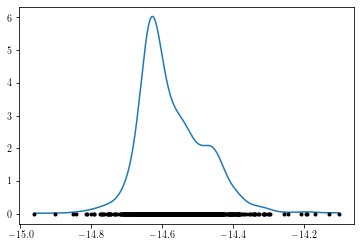

In [72]:
FTCLE = avg10.FTCLE[:, 2]
x_d = np.linspace(FTCLE.min(), FTCLE.max(), 1000)
kde = gaussian_kde(FTCLE)
pdf = kde.evaluate(x_d)
plt.plot(x_d, pdf)
plt.plot(FTCLE, np.full_like(FTCLE, -0.01), '.k')

In [3]:
# FTCLE Histogram

def clehist(data, bins, leindex, save = False):
    """ Function for plotting histograms of FTCLEs.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, bins: number of bins in histogram.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    option, save: boolean.
    """
    les = ['$\\bar{\\lambda}_1 ^C$', '$\\bar{\\lambda}_2 ^C$', '$\\bar{\\lambda}_3 ^C$']
    for j in leindex: # Loop over LE indexes
        plt.figure()
        index = j - 1 # Python indexing is one less than intuitive LE index
        
        for i in data: # This loop produce the histograms for differen tau
            Ltau = i.L * i.param_dict['tau']
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            plt.hist(i.FTCLE[:, index], bins = bins, histtype = 'step', density = True, label = label) # First CLE
        
        plt.title(f'{les[index]} Densities') # Plot features
        plt.ylabel('$\\rho$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'FTCLE{j}-Densities.png', dpi=1200)
        else:    
            plt.show() 

In [377]:
# FTBLE Histogram

def blehist(data, bins, leindex, save = False):
    """ Function for plotting histograms of FTBLEs.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, bins: number of bins in histogram.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    """
    les = ['$\\bar{\\lambda}_1 ^B$', '$\\bar{\\lambda}_2 ^B$', '$\\bar{\\lambda}_3 ^B$']
    for j in leindex: # Loop over LE indexes
        plt.figure()
        index = j - 1 # Python indexing is one less than intuitive LE index
        
        for i in data: # This loop produce the histograms for differen tau
            Ltau = i.L * i.param_dict['tau']
            label = '$L\\tau =' + f"{Ltau:.2f}" + '$' # Tau in adimensional time
            plt.hist(i.FTBLE[:, index], bins = bins, histtype = 'step', density = True, label = label) # First CLE
        
        plt.title(f'{les[index]} Densities') # Plot features
        plt.ylabel('$\\rho$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'FTBLE{j}-Densities.png', dpi = 1200)
        else:    
            plt.show() 



In [378]:
# Comparing FTBLE and FTCLE histograms for fixed averaging time

def comphist(data, bins, leindex, save = False):
    """ Function for plotting histograms comparison of FTBLEs and FTCLEs.
    param, data, array: Array of data we're plotting. Should come from DataRead.
    param, bins: number of bins in histogram.
    param, leindex, integer: can be array, indiced of LEs we're plotting
    """
    les = ['$\\lambda_1$', '$\\lambda_2$', '$\\lambda_3$']
    Ltau = data.L * data.param_dict['tau'] # SHOULD BE THE SAME FOR DATAB AND DATAC, this L * tau
        
    for j in leindex: # Loop over LE indexes
        plt.figure()
        index = j - 1 # Python indexing is one less than intuitive LE index
        
        labelb = 'FTBLE' # Tau in adimensional time
        labelc = 'FTCLE' # Tau in adimensional time
        
        plt.hist(data.FTBLE[:, index], bins = bins, histtype = 'step', density = True, label = labelb) # BLEs
        plt.hist(data.FTCLE[:, index], bins = bins, histtype = 'step', density = True, label = labelc) # BLEs
        
        plt.title(f'{les[index]} Density, ' + '$L\\tau =' + f"{Ltau:.2f}" + '$') # Plot features
        plt.ylabel('$\\rho$')
        plt.legend()
        
        # DO YOU WANT TO SAVE THE FIGURE OR LOOK AT IT
        if (save):
            plt.savefig(f'Density-Ltau={Ltau:.2f}-FTBLE{j}vsFTCLE{j}.png', dpi = 1200)
        else:    
            plt.show() 